In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from itertools import combinations
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Adjust width to avoid line wrapping
pd.set_option('display.max_colwidth', None)  # Display full content in each cell

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# File path
file_path = "/content/drive/MyDrive/Research/Heart-Failure/Data/Filtered_Data.csv"
file_path_md = "/content/drive/MyDrive/Research/Heart-Failure/Data/dat_md.csv"
# Load CSV into DataFrame
filtered_data = pd.read_csv(file_path)
meds = pd.read_csv(file_path_md)

In [4]:
filtered_data.head()

,Unnamed: 0,inpatient.number,DestinationDischarge,admission.ward,admission.way,discharge.department,visit.times,gender,body.temperature,pulse,respiration,systolic.blood.pressure,diastolic.blood.pressure,map,weight,height,BMI,type.of.heart.failure,NYHA.cardiac.function.classification,Killip.grade,myocardial.infarction,congestive.heart.failure,peripheral.vascular.disease,cerebrovascular.disease,dementia,Chronic.obstructive.pulmonary.disease,connective.tissue.disease,diabetes,hemiplegia,leukemia,malignant.lymphoma,solid.tumor,AIDS,type.II.respiratory.failure,consciousness,eye.opening,verbal.response,movement,oxygen.inhalation,fio2,acute.renal.failure,outcome.during.hospitalization,death.within.28.days,re.admission.within.28.days,death.within.3.months,re.admission.within.3.months,death.within.6.months,re.admission.within.6.months,GCS,dischargeDay,ageCat,mean.corpuscular.volume,hemoglobin,mean.hemoglobin.volume,hematocrit,occupation,neutrophil.count,neutrophil.ratio,platelet,eosinophil.count,eosinophil.ratio,basophil.count,basophil.ratio,mean.hemoglobin.concentration,lymphocyte.count,red.blood.cell,monocyte.count,monocyte.ratio,white.blood.cell,uric.acid,urea,creatinine.enzymatic.method,carbon.dioxide.binding.capacity,chloride,potassium,calcium,sodium,CCI.score,moderate.to.severe.chronic.kidney.disease,peptic.ulcer.disease,liver.disease,return.to.emergency.department.within.6.months
0,1,857781,Home,Cardiology,NonEmergency,Cardiology,1,Male,36.7,87,19,102,64,76.666667,50.0,1.64,18.590125,Both,III,III,0,0,0,0,0,1,0,1,0,0,0,0,0,NonTypeII,Clear,4,5,6,OxygenTherapy,33,0,Alive,0,0,0,0,0,0,15,11,"(69,79]",94.5,131.0,32.0,0.387,UrbanResident,7.05,0.746,102.0,0.02,0.002,0.05,0.006,338.0,1.51,4.09,0.80,0.085,9.43,685.0,12.55,108.3,21.6,101.9,5.59,2.28,134.6,2.0,0.0,0.0,0.0,0.0
1,2,743087,Home,Cardiology,NonEmergency,Cardiology,1,Female,36.8,95,18,150,70,96.666667,51.0,1.63,19.195303,Both,III,I,0,0,0,0,0,0,0,0,0,0,0,0,0,NonTypeII,Clear,4,5,6,OxygenTherapy,33,0,Alive,0,0,0,0,0,0,15,8,"(69,79]",88.6,114.0,28.9,0.349,UrbanResident,3.73,0.702,123.0,0.05,0.009,0.01,0.002,326.0,1.18,3.93,0.35,0.066,5.32,170.0,4.29,62.0,26.5,105.6,3.62,2.28,144.0,0.0,0.0,0.0,0.0,0.0
2,3,866418,Home,Cardiology,NonEmergency,Cardiology,2,Male,36.5,98,18,102,67,78.666667,70.0,1.70,24.221453,Both,II,II,0,0,0,0,0,0,0,0,0,0,0,0,0,NonTypeII,Clear,4,5,6,OxygenTherapy,33,0,Alive,0,0,0,0,0,0,15,5,"(59,69]",96.4,144.0,32.6,0.427,farmer,11.54,0.887,169.0,0.02,0.002,0.03,0.002,339.0,0.75,4.43,0.67,0.051,13.01,567.0,15.99,185.1,21.6,107.0,4.15,2.56,142.2,0.0,0.0,0.0,0.0,0.0
3,4,775928,Home,Cardiology,Emergency,Cardiology,1,Male,36.0,73,19,110,74,86.000000,65.0,1.70,22.491349,Both,III,II,0,0,0,0,0,1,0,0,0,0,0,0,0,NonTypeII,Clear,4,5,6,OxygenTherapy,33,0,Alive,0,1,0,1,0,1,15,11,"(69,79]",102.2,94.0,34.7,0.277,UrbanResident,1.22,0.559,35.0,0.06,0.028,0.00,0.000,339.0,0.71,2.71,0.19,0.087,2.18,635.0,8.16,104.8,21.1,101.6,3.76,2.35,136.3,2.0,1.0,0.0,0.0,1.0
4,5,810128,Home,Cardiology,NonEmergency,Cardiology,1,Female,35.0,88,19,134,62,86.000000,76.0,1.55,31.633715,Both,III,II,0,0,0,0,0,0,0,0,0,0,0,0,0,NonTypeII,Clear,4,5,6,OxygenTherapy,33,0,Alive,0,0,0,0,0,0,15,5,"(69,79]",90.0,120.0,28.6,0.378,UrbanResident,4.28,0.697,104.0,0.05,0.008,0.01,0.002,317.0,1.27,4.20,0.53,0.086,6.14,432.0,6.86,83.9,22.8,104.3,3.94,2.42,136.6,0.0,0.0,0.0,0.0,0.0


In [5]:
meds.head()

,Unnamed: 0,inpatient.number,Drug_name
0,1,857781,sulfotanshinone sodium injection
1,2,857781,Furosemide tablet
2,3,857781,Enoxaparin Sodium injection
3,4,857781,Meglumine Adenosine Cyclophosphate for injection
4,5,857781,Furosemide injection


# Cohort Analysis

# 1. Mortality Rate by Age Group and Comorbidities


**What We Are Doing**

This analysis examines the mortality rates within 28 days of discharge across different age groups and the presence of comorbid conditions such as Chronic Obstructive Pulmonary Disease (COPD) and Diabetes.

**We aim to:**
1. Understand how age and comorbidities affect short-term mortality.
2. Identify high-risk patient groups based on age and specific comorbid conditions.

**How It Helps:**
1. Risk Stratification: By identifying age groups and comorbidities associated with higher mortality rates, healthcare providers can prioritize care for high-risk patients.
2. Tailored Interventions: Helps in designing targeted interventions and post-discharge follow-ups for patients who are older or have specific comorbidities.
3. Resource Allocation: Assists hospital administration in allocating resources effectively to improve patient outcomes.

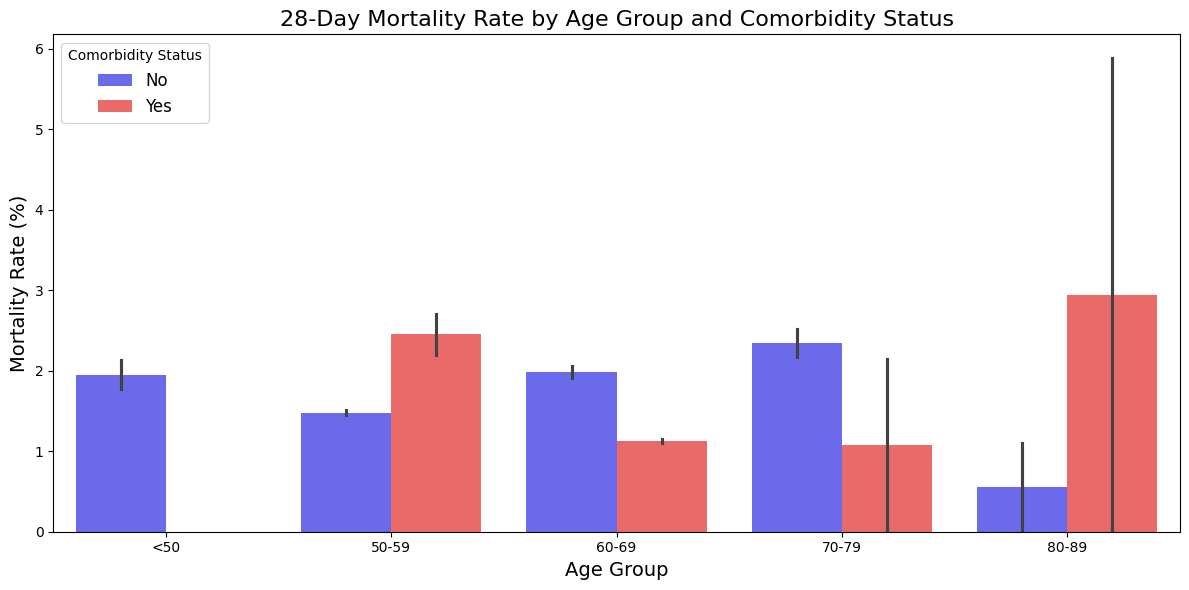

In [28]:

# Ensure 'ageCat' is of string type
filtered_data['ageCat'] = filtered_data['ageCat'].astype(str)

# Extract numerical values from 'ageCat'
filtered_data['ageCat'] = filtered_data['ageCat'].str.extract('(\d+)', expand=False)

# Handle missing values
filtered_data['ageCat'] = filtered_data['ageCat'].fillna(0)

# Convert 'ageCat' to integer
filtered_data['ageCat'] = filtered_data['ageCat'].astype(int)

# Create age bins
filtered_data['Age_Group'] = pd.cut(
    filtered_data['ageCat'],
    bins=[0, 49, 59, 69, 79, 89],
    labels=['<50', '50-59', '60-69', '70-79', '80-89']
)

# Select comorbidities to analyze
comorbidities = ['Chronic.obstructive.pulmonary.disease', 'diabetes']

# Melt the comorbidities into long format
melted_data = pd.melt(
    filtered_data,
    id_vars=['death.within.28.days', 'Age_Group'],
    value_vars=comorbidities,
    var_name='Comorbidity',
    value_name='Status'
)

# Map comorbidities and statuses to readable labels
melted_data['Comorbidity'] = melted_data['Comorbidity'].map({
    'Chronic.obstructive.pulmonary.disease': 'COPD',
    'diabetes': 'Diabetes'
})
melted_data['Status'] = melted_data['Status'].map({1: 'Yes', 0: 'No'})

# Remove rows with missing Age_Group
melted_data = melted_data.dropna(subset=['Age_Group'])

# Calculate mortality rates
mortality_data = melted_data.groupby(['Age_Group', 'Comorbidity', 'Status'])['death.within.28.days'].mean().reset_index()
mortality_data['death.within.28.days'] *= 100  # Convert to percentage

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(
    data=mortality_data,
    x='Age_Group',
    y='death.within.28.days',
    hue='Status',
    palette='seismic'
)
plt.title('28-Day Mortality Rate by Age Group and Comorbidity Status', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Mortality Rate (%)', fontsize=14)
plt.legend(title='Comorbidity Status', fontsize=12)
plt.tight_layout()
plt.show()

# 2. Readmission Rates by Admission Type and Department


**What We Are Doing**
Examining how readmission rates within 28 days vary based on the admission way (Emergency vs. NonEmergency) and the department to which the patient was admitted.

**We aim to:**

1. Identify departments with higher readmission rates.
2. Understand the impact of emergency admissions on readmission rates.
**How It Helps**
1. Departmental Performance: Helps in evaluating departmental protocols and identifying areas needing improvement.
2. Emergency Care Improvement: Provides insights into emergency care processes that may contribute to readmissions.
3. Policy Development: Assists in formulating policies to reduce readmission rates and improve patient care continuity.

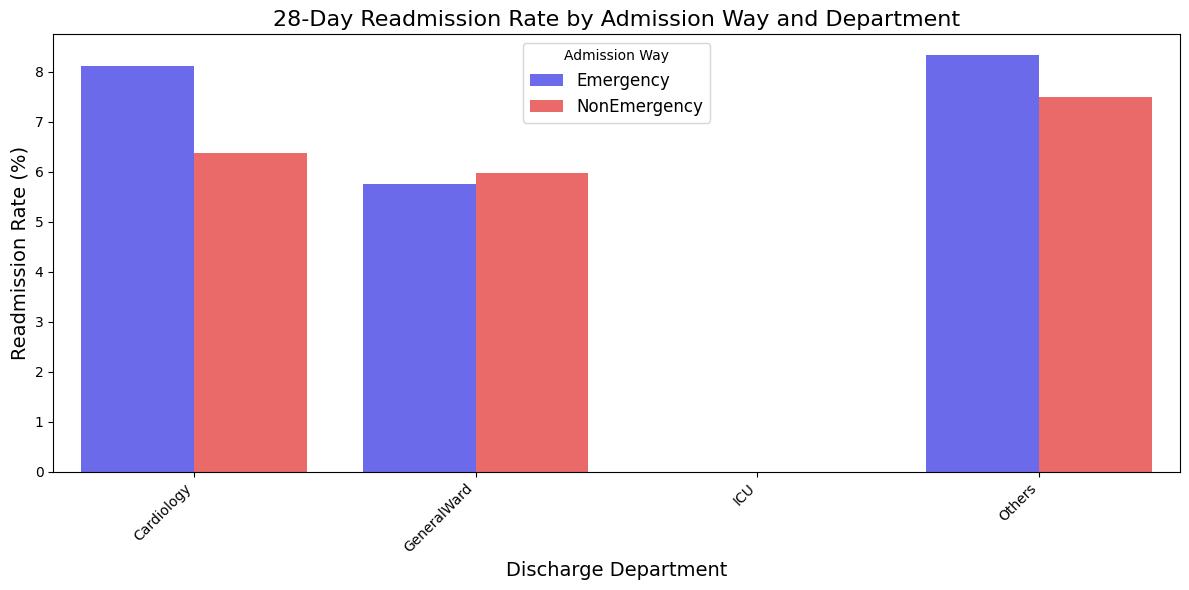

In [23]:

# Calculate readmission rates by admission way and department
readmission_data = filtered_data.groupby(['admission.way', 'discharge.department'])['re.admission.within.28.days'].mean().reset_index()
readmission_data['re.admission.within.28.days'] *= 100  # Convert to percentage

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(
    data=readmission_data,
    x='discharge.department',
    y='re.admission.within.28.days',
    hue='admission.way',
    palette='seismic'
)
plt.title('28-Day Readmission Rate by Admission Way and Department', fontsize=16)
plt.xlabel('Discharge Department', fontsize=14)
plt.ylabel('Readmission Rate (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Admission Way', fontsize=12)
plt.tight_layout()
plt.show()

# 3. Medication Effectiveness on Patient Outcomes

**What We Are Doing**

This analysis examines the relationship between specific medications and patient mortality within 28 days of discharge.
We are identifying medications that are correlated with higher mortality rates among patients.

**We aim to:**

Identify medications associated with higher mortality rates.
Understand the clinical contexts in which these medications are used.

**How It Helps**

1. Clinical Awareness: Raises awareness among healthcare providers about medications associated with higher mortality rates, prompting a review of prescribing practices.
2. Medication Review: Encourages further investigation into whether these medications are being used appropriately and if alternative treatments could improve patient outcomes.
3. Resource Allocation: Assists hospital administration in allocating resources for additional patient monitoring or support when high-risk medications are prescribed.

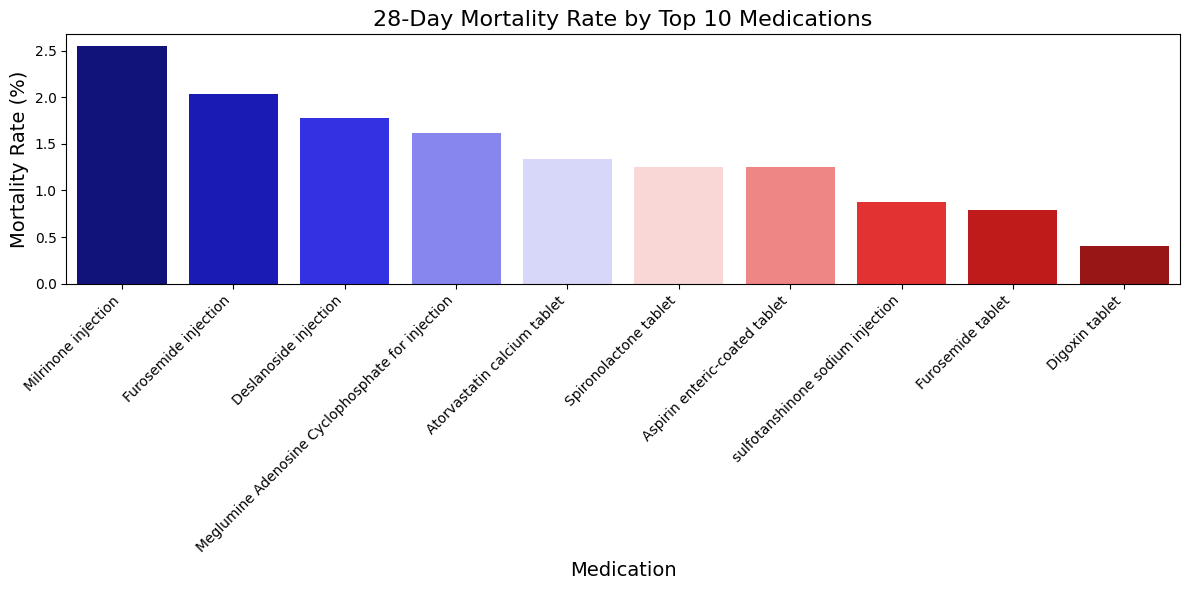

In [24]:

# Merge medication data with patient outcomes
medication_outcome = pd.merge(
    meds,
    filtered_data[['inpatient.number', 'death.within.28.days']],
    on='inpatient.number'
)

# Calculate mortality rates per medication
med_mortality = medication_outcome.groupby('Drug_name')['death.within.28.days'].mean().reset_index()
med_mortality['death.within.28.days'] *= 100  # Convert to percentage

# Get top 10 medications by frequency
top_meds = medication_outcome['Drug_name'].value_counts().head(10).index
top_med_mortality = med_mortality[med_mortality['Drug_name'].isin(top_meds)]

# Sort medications by mortality rate in descending order
top_med_mortality = top_med_mortality.sort_values(by='death.within.28.days', ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_med_mortality,
    x='Drug_name',
    y='death.within.28.days',
    palette='seismic'
)
plt.title('28-Day Mortality Rate by Top 10 Medications', fontsize=16)
plt.xlabel('Medication', fontsize=14)
plt.ylabel('Mortality Rate (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4. Medication Prescriptions by Comorbidity Status

**What We Are Doing:**
* Analyzing how medication prescriptions vary between patients with and without a specific comorbidity, such as **Diabetes**  and **Chronic Kidney Disease**.
* Visualizing the top medications prescribed to patients based on their comorbidity status.

**How It Helps**
1. Targeted Treatment Strategies: Helps understand which medications are commonly prescribed to patients with certain comorbidities, aiding in developing targeted treatment plans.
2. Medication Management: Assists in monitoring medication usage patterns among high-risk patient groups.
3. Clinical Insights: Provides insights into prescribing practices for patients with specific health conditions.

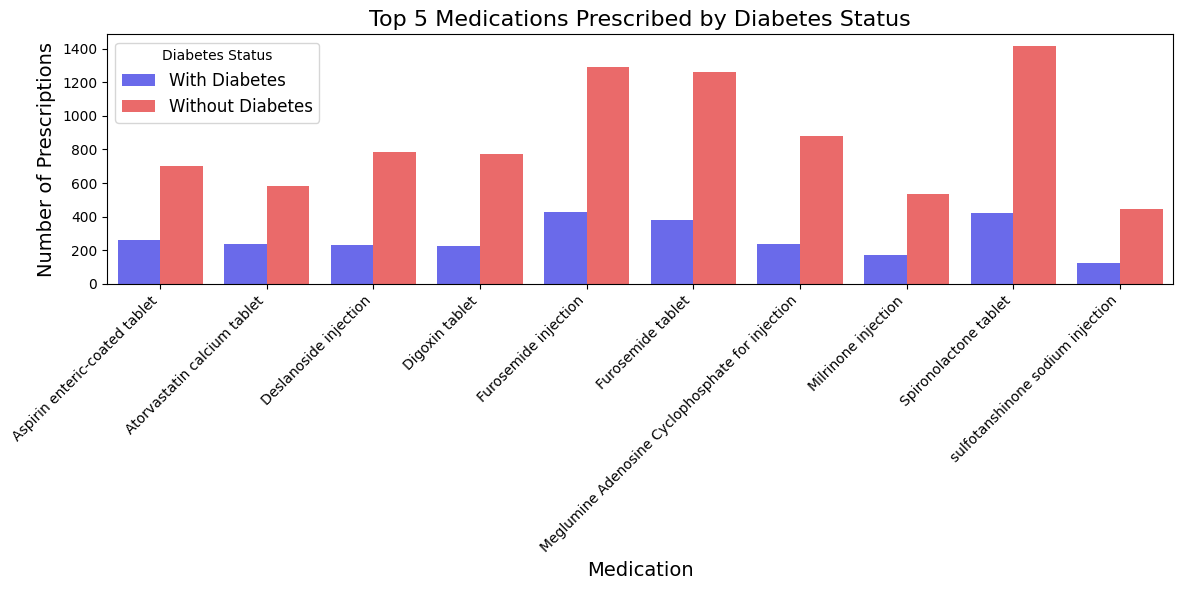

In [25]:

# Merge medications with patient comorbidity information
meds_comorbidity = pd.merge(
    meds,
    filtered_data[['inpatient.number', 'diabetes']],
    on='inpatient.number'
)

# Map comorbidity status to readable labels
meds_comorbidity['Diabetes_Status'] = meds_comorbidity['diabetes'].map({1: 'With Diabetes', 0: 'Without Diabetes'})

# Get top 5 medications overall
top_medications = meds['Drug_name'].value_counts().head(10).index

# Filter data for top medications
meds_comorbidity_filtered = meds_comorbidity[meds_comorbidity['Drug_name'].isin(top_medications)]

# Count the number of prescriptions per medication and comorbidity status
med_comorbidity_counts = meds_comorbidity_filtered.groupby(['Drug_name', 'Diabetes_Status']).size().reset_index(name='Count')

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(
    data=med_comorbidity_counts,
    x='Drug_name',
    y='Count',
    hue='Diabetes_Status',
    palette='seismic'
)
plt.title('Top 5 Medications Prescribed by Diabetes Status', fontsize=16)
plt.xlabel('Medication', fontsize=14)
plt.ylabel('Number of Prescriptions', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Diabetes Status', fontsize=12)
plt.tight_layout()
plt.show()

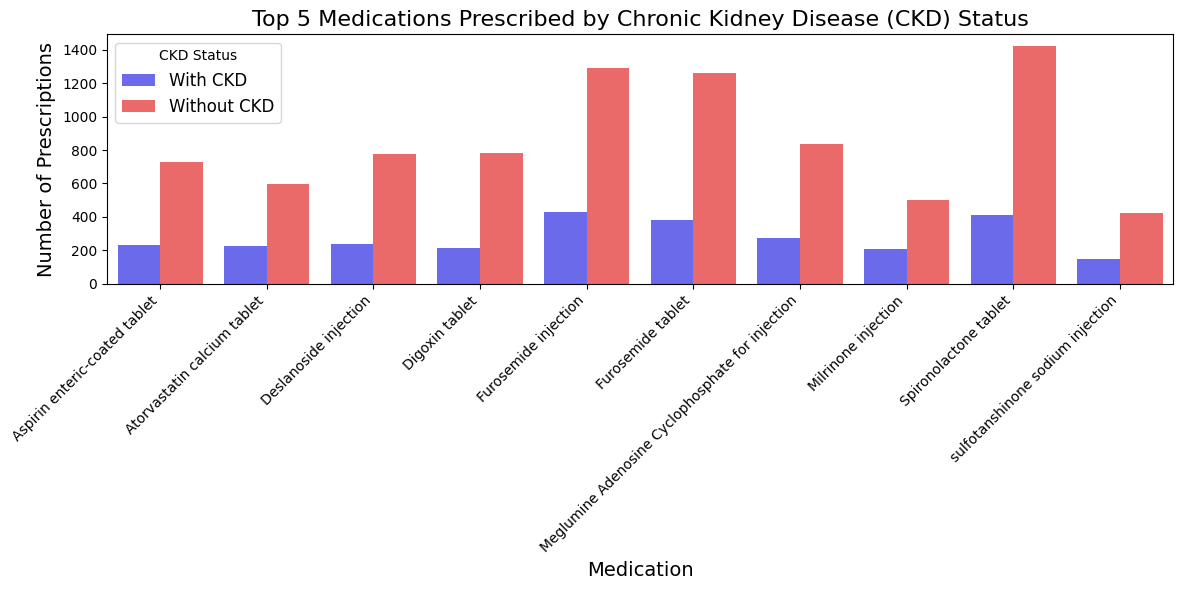

In [26]:

# Merge medications with patient comorbidity information
meds_comorbidity = pd.merge(
    meds,
    filtered_data[['inpatient.number', 'moderate.to.severe.chronic.kidney.disease']],
    on='inpatient.number'
)

# Map comorbidity status to readable labels
meds_comorbidity['CKD_Status'] = meds_comorbidity['moderate.to.severe.chronic.kidney.disease'].map({1: 'With CKD', 0: 'Without CKD'})

# Get top 5 medications overall
top_medications = meds['Drug_name'].value_counts().head(10).index

# Filter data for top medications
meds_comorbidity_filtered = meds_comorbidity[meds_comorbidity['Drug_name'].isin(top_medications)]

# Count the number of prescriptions per medication and comorbidity status
med_comorbidity_counts = meds_comorbidity_filtered.groupby(['Drug_name', 'CKD_Status']).size().reset_index(name='Count')

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(
    data=med_comorbidity_counts,
    x='Drug_name',
    y='Count',
    hue='CKD_Status',
    palette='seismic'
)
plt.title('Top 5 Medications Prescribed by Chronic Kidney Disease (CKD) Status', fontsize=16)
plt.xlabel('Medication', fontsize=14)
plt.ylabel('Number of Prescriptions', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='CKD Status', fontsize=12)
plt.tight_layout()
plt.show()

# 5. Relationship Between Number of Medications Prescribed and Length of Stay


**What We Are Doing:**
* Calculating the number of medications prescribed to each patient.
Analyzing how the number of medications relates to the Length of Stay (LOS).
* Visualizing the relationship using a scatter plot with a regression line.

**How It Helps:**
1. Polypharmacy Awareness: Identifies whether patients receiving more medications tend to have longer hospital stays, indicating the impact of polypharmacy.
2. Resource Utilization: Helps understand how medication load affects hospital resources and patient care.
3. Clinical Decision-Making: Encourages clinicians to review medication regimens to optimize patient outcomes and potentially reduce LOS.

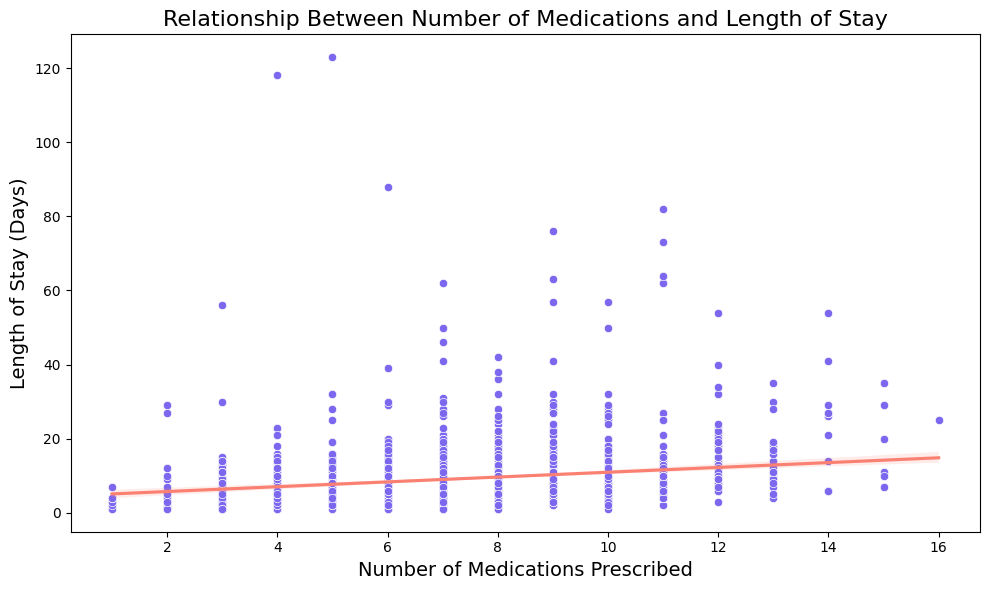

In [30]:

# Calculate the number of medications prescribed to each patient
med_counts = meds.groupby('inpatient.number').size().reset_index(name='Medication_Count')

# Merge with patient Length of Stay information
med_los = pd.merge(
    med_counts,
    filtered_data[['inpatient.number', 'dischargeDay']],
    on='inpatient.number'
)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=med_los,
    x='Medication_Count',
    y='dischargeDay',
    color='mediumslateblue'
)
sns.regplot(
    data=med_los,
    x='Medication_Count',
    y='dischargeDay',
    scatter=False,
    color='salmon'
)
plt.title('Relationship Between Number of Medications and Length of Stay', fontsize=16)
plt.xlabel('Number of Medications Prescribed', fontsize=14)
plt.ylabel('Length of Stay (Days)', fontsize=14)
plt.tight_layout()
plt.show()